Utilização do modelo preditivo: Para esta etapa do trabalho é necessário estipular um valor suficiente para que transforme a curva estudada em uma objetivo. Para isso, confiaremos e consideraremos a equação de Schrödinger no que diz respeito ao potencial harmônico, V(x,u(t)).

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

In [2]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psi(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

In [3]:
'''
Método de Crank-Nicolson para a solução da equação de Schrödinger em uma única dimensão
    ih * u_t = h_2/2m * u_xx + V_xt * u

Com as condições de contorno não incluídas nessa etapa para que o controle preditivo faça as alterações
Com a equação inicial sendo decidida pelos polinômios de hermite de primeiro e segundo grau

u(x,0) = 0.80 * psi(0, x) + 0.60 * psi(1,x)

A interpretação foi ajustada a partir do código em python da Msc. Mirian Silva
'''

def CrankNicolson(M, O = 0, L = 1, T = 0.5):
    N = 1000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    us = np.linspace(-5, 5, 1000)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2+us #V(x,u(t))

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    psi_c = np.zeros((M, N))

    #Condição inicial
    ps[:,0] = 0.80 * psi(0, xs) + 0.60 * psi(1,xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
    psi_c = ps.astype(complex)
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    return (psi_c, ts, xs)

psi, ts, xs = CrankNicolson(M = 1000, O = -5, L = 5, T = 10)

In [4]:
def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    #print(type(n))
    Pxt = N(n)*Hn(x.real)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

In [5]:
def ExactSolution(M, T = 1000, L = 5):
    N = 1000

    xs = np.linspace(-5, L, M)
    ts = np.linspace(0, N/100, T)
    
    psiExato = np.zeros((M, N)).astype(complex)
    r=0
    for i in np.arange(-5, 5, 0.01):
        for j in np.arange(0, 10, 0.01):
            psiExato[r][int(round(j*100,1))] = 1/np.sqrt(2)*psixt(0,i,j)+1/np.sqrt(2)*psixt(1,i,j)
        r+=1
    
    return (psiExato, ts, xs)

In [6]:
vetor = []

In [7]:
psi_d = np.zeros((1000,1000))
psi_d, p, r = ExactSolution(M = 1000)
print(psi_d[1][3])

(-1.2458470516880618e-05+1.970887281154517e-06j)


In [8]:
print(psi[2][3])

(1.111523600204212e-06+3.759814055089497e-06j)


In [9]:
print(psi_d[2][3])

(-1.3064644501103767e-05+2.0672680490014274e-06j)


In [10]:
def FuncDE(x):
    return 1/np.sqrt(2) * psixt(0, x[0], x[1]) + 1/np.sqrt(2) * psixt(1, x[0], x[1])

#Avaliação do gradiente
def gradiente(x, funcDA):
    h = 0.01
    grad = []
    
    for i in range(len(x)):
        xh = x.copy()
        xh[i] = xh[i] + 0.0 + h
        # Deve haver uma conversão de posição da matriz para ponto da curva
        dx = (FuncDE(xh)-funcDA[int(np.round(((xh[0]+5)*100),0))][int(np.round((xh[1]*100),0))]) - (FuncDE(x)-funcDA[int(np.round(((xh[0]+5)*100),0))][int(np.round((x[1]*100),0))])/h
        grad.append(dx.real)
    return grad

#Método gradiente
def methodGrad(x):
    k = 0
    kmax = 5000
    #x = np.array([-3/2., 5/2.])
    
    while(k < kmax):
        d = -1*np.array(gradiente(x, psi))
        alpha = 0.01
        x = x + alpha*d
        k += 1
        
    x_otimo = x
    return x_otimo

In [11]:
x = np.array([-4.0, 0.0])
print(methodGrad(x))

[-4.33346618 -0.32499705]


Considerando que a nossa função objetivo é a diferença entre a função exata e o psi estudado até o momento, utilizamos o método gradiente para estimar o valor de x e de t para que alcance o valor ideal. No primeiro teste considerou-se -5 e 0, onde -5 envolve o valor de x e de u, já que V, o potêncial harmônico depende destes. Então, para que se alcance o valor exato é preciso variar o x e o t em pequenos valores, em intervalos de $10^{-3}$.

Para o algoritmo MPC é necessário realizar o método gradiente algumas vezes e utilizar sempre o primeiro termo e posteriormente fazê-lo para todo o tempo estudado. 

In [12]:
i = 0
for i in range(i+3):
    #Deve-se utilizar Crank-Nicolson antes de entrar no método gradiente
    vetor.append(methodGrad(x))
    x[0] = x[0] + 0.01
A = vetor[0]

In [13]:
print(vetor)

[array([-4.33346618, -0.32499705]), array([-4.32449696, -0.32499413]), array([-4.31509053, -0.32464942])]


Toda vez que obtemos um conjunto de valores do método gradiente, utilizamos o primeiro para realizar a operação $$\psi_{i+1}=V[A] \cdot \psi_i$$ Esse próximo fator será utilizado no Crank-Nicolson e o método gradiente se tornará necessário.

In [14]:
def CrankNicolsonSimplificado(psi_c, M, O = 0, L = 1, T = 0.5):
    N = 1000 #São os pontos no intervalo de tempo
    
    #Pensando no poço quadrado infinito, temos essas duas limitações, onde L varia
    x0, xL = O, L

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = (xL - x0)/(P*M-1) 

    #Discretização temporal
    t0, tF = 0, T
    dt = (tF - t0)/(P*N-1)

    #Retorno dos números em um intervalo
    xs = np.linspace(x0, xL, M)
    ts = np.linspace(t0, tF, N)
    us = np.linspace(-5, 5, 1000)

    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*xs**2+us #V(x,u(t))

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    #Obtenção da matriz psi (Ela acumulará para o psi futuro)
    ps = np.zeros((M, N))
    
    #For para o acúmulo de resultados
    for k in range(1,N):
        b = np.matmul(matrizB, np.array(psi_c[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi_c[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
        #plt.plot(xs, np.absolute(psi_c[0:M, k])**2)
    #plt.plot(xs, np.absolute(psi_c[0:M, 0:1000])**2)
    return (psi_c, ts, xs)

In [15]:
def FuncDE(x):
    return 1/np.sqrt(2) * psixt(0, x[0], x[1]) + 1/np.sqrt(2) * psixt(1, x[0], x[1])

#Avaliação do gradiente
def gradiente(x, funcDA):
    h = 0.01
    grad = []
    
    for i in range(len(x)):
        xh = x.copy()
        xh[i] = xh[i] + 0.0 + h
        # Deve haver uma conversão de posição da matriz para ponto da curva
        dx = (FuncDE(xh)-funcDA[int(np.round(((xh[0]+5)*100),0))][int(np.round((xh[1]*100),0))]) - (FuncDE(x)-funcDA[int(np.round(((xh[0]+5)*100),0))][int(np.round((x[1]*100),0))])/h
        grad.append(dx.real)
    return grad

#Método gradiente
def methodGrad(x, psi):
    k = 0
    kmax = 5000
    #x = np.array([-3/2., 5/2.])
    
    while(k < kmax):
        d = -1*np.array(gradiente(x, psi))
        alpha = 0.01
        x = x + alpha*d
        k += 1
        
    x_otimo = x
    return x_otimo

In [16]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psi(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    #print(type(n))
    Pxt = N(n)*Hn(x.real)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

[-4.33346618 -0.32499705]
[-4.97403069 -2.94432599]
[-1.31835421  0.75964855]
[-0.95911072  0.1167943 ]
[-1.37199488 -0.06928169]
[-1.05412018 -0.10643927]
[-3.5162044  -1.49760234]
[-4.97511743 -2.92538046]
[-1.0692046   0.97967345]
[-4.8432081  -1.44638215]


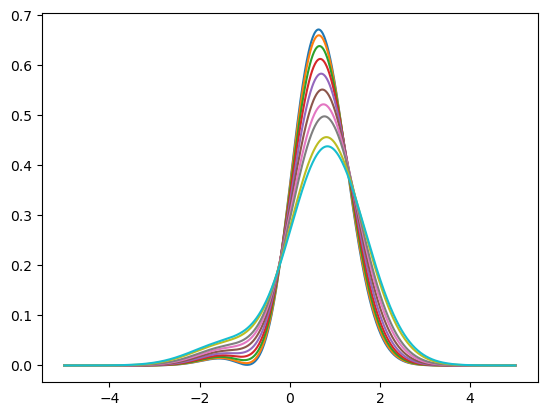

In [17]:
ps = np.zeros((1000, 1000))
psi_c = np.zeros((1000, 1000))
ps[:,0] = 0.80 * psi(0, xs) + 0.60 * psi(1,xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
psi_c = ps.astype(complex)
psi, ts, xs = CrankNicolsonSimplificado(psi_c, M = 1000, O = -5, L = 5, T = 10)

i = 0
y = np.array([-2.0,0.0])
t = y.copy()
for u in range(10):
    for i in range(i, i+3):
        vetor.append(methodGrad(y, psi))
        y[0] = y[0] + 0.01
    A = vetor[0]
    print(A)
    i+=1
    vetor = []
    t[0] = t[0] + 0.01
    y = t.copy()
    
    
    #Retorno dos números em um intervalo
    xs = np.linspace(-5, 5, 1000)
    ts = np.linspace(0, 10, 1000)
    us = np.linspace(-5, 5, 1000)

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = 10/(P*1000-1) 

    #Discretização temporal
    t0, tF = 0, 10
    dt = (tF - t0)/(P*1000-1)
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*(A[0])**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    M = 1000
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    for k in range(1, 1000):
        b = np.matmul(matrizB, np.array(psi[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
    
    plt.plot(xs, np.absolute(psi[0:M, i])**2)
    #psi, ts, xs = CrankNicolsonSimplificado(psi, M = 1000, O = -5, L = 5, T = 10)


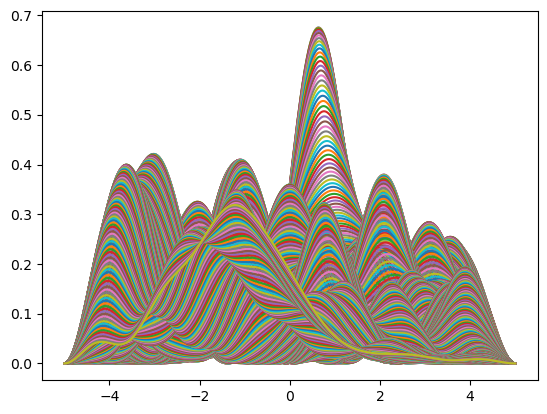

In [18]:
for i in range(0,999):
    plt.plot(xs, np.absolute(psi[0:M, i])**2)

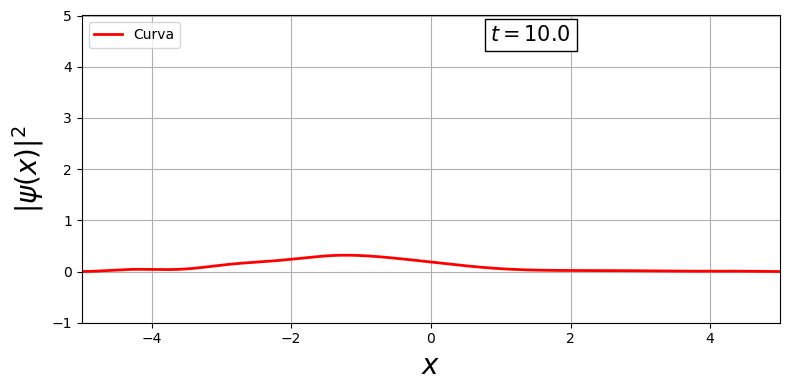

In [19]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    ln1.set_data(xs, np.absolute(psi[0:1000,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Curva')
time_text = ax.text(0.85, 4.5, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 5)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=200)
ani.save('QuantControl.gif',writer='pillow',fps=50,dpi=100)

In [20]:
def N(n):
    return 1*1./np.sqrt(np.sqrt(np.pi)*2**n*factorial(n))

def psi(n, x):
    Hn=hermite(n)
    Px = N(n)*Hn(x)*np.exp(-0.5*x**2)
    return Px

def psixt(n, x, t):
    Hn=hermite(n)
    a = complex(0,1)
    #print(type(n))
    Pxt = N(n)*Hn(x.real)*np.exp(-0.5*x**2)*np.exp(-a*(n+1/2)*t*np.pi)
    return Pxt

[-0.66138416  0.04713626]
[-0.71496204 -0.00382787]
[-0.7864931  -0.07157419]
[-0.73109526 -0.01670139]
[-0.75739287 -0.04320793]
[-0.72236301 -0.01242337]
[-0.62434551  0.08022812]
[-0.67444275  0.03434042]
[-0.8000865  -0.08412365]
[-0.62967307  0.07789203]


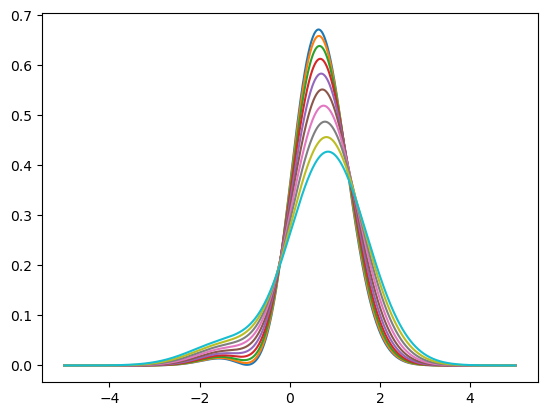

In [21]:
ps = np.zeros((1000, 1000))
psi_c = np.zeros((1000, 1000))
ps[:,0] = 0.80 * psi(0, xs) + 0.60 * psi(1,xs) #A primeira coluna da matriz terá a equação inicial, em todas as posições
psi_c = ps.astype(complex)
psi, ts, xs = CrankNicolsonSimplificado(psi_c, M = 1000, O = -5, L = 5, T = 10)

i = 0
y = np.array([-2.0,0.0])
t = y.copy()
for u in range(10):
    for i in range(i, i+3):
        vetor.append(methodGrad(y, psi))
        y[0] = y[0] + 0.01
    A = vetor[0]
    print(A)
    i+=1
    vetor = []
    t[0] = t[0] + 0.01
    y = t.copy()
    
    
    #Retorno dos números em um intervalo
    xs = np.linspace(-5, 5, 1000)
    ts = np.linspace(0, 10, 1000)
    us = np.linspace(-5, 5, 1000)

    P = 3.141111111111111111111111111
    #Discretização espacial
    dx = 10/(P*1000-1) 

    #Discretização temporal
    t0, tF = 0, 10
    dt = (tF - t0)/(P*1000-1)
    #Suponha um oscilador harmônico simples
    hbar = 1
    m = 1
    w = np.pi
    V = 1/2*m*w**2*(A[0])**2

    #A partir da demonstração
    a = hbar/(4*m*dx**2) 
    b = 1j*hbar/dt - 2*a - 1/2*V
    c = 1j*hbar/dt + 2*a + 1/2*V

    #Obtenção da matriz
    M = 1000
    ##Diagonais principais
    diagPrincipalA = b*np.ones((1,M)) #Cria uma matriz de 1's
    diagPrincipalB = c*np.ones((1,M))

    ##Diagonais secundárias, tem um tamanho a menos
    diagSecundariaA = a*np.ones((1,M-1))
    diagSecundariaB = (-a)*np.ones((1,M-1))

    diagonaisA = [diagPrincipalA, diagSecundariaA, diagSecundariaA]
    matrizA = sparse.diags(diagonaisA, [0, -1, 1], shape=(M,M)).toarray()
    
    diagonaisB = [diagPrincipalB, diagSecundariaB, diagSecundariaB]         
    matrizB = sparse.diags(diagonaisB, [0, -1, 1], shape=(M,M)).toarray()
    
    for k in range(1, 1000):
        b = np.matmul(matrizB, np.array(psi[0:M, k-1])) #Multiplicação de arrays já que houve uma conversão anterior
        psi[0:M, k] = np.linalg.solve(matrizA, b) #Matlab: x = A\b
    
    plt.plot(xs, np.absolute(psi[0:M, i])**2)
    psi, ts, xs = CrankNicolsonSimplificado(psi, M = 1000, O = -5, L = 5, T = 10)


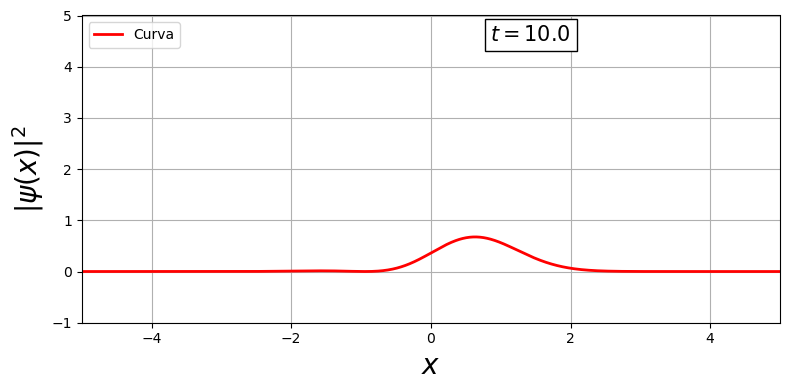

In [22]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

def animate(i):
    ln1.set_data(xs, np.absolute(psi[0:1000,i-1])**2)
    time_text.set_text('$t=$'+'{:.1f}'.format(i/100))
    
fig, ax = plt.subplots(1, 1,figsize=(8,4))
ax.grid()
ln1, = plt.plot([], [], 'r-', lw=2, markersize=8, label='Curva')
time_text = ax.text(0.85, 4.5, '', fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black'))
ax.set_ylim(-1, 5)
ax.set_xlim(-5,5)
title = ax.set_title('Resposta analítica')
ax.set_ylabel('$|\psi(x)|^2$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.legend(loc='upper left')
ax.set_title('')
plt.tight_layout()
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=200)
ani.save('QuantControl2.gif',writer='pillow',fps=50,dpi=100)